In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.datasets import STL10

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
stl10_dataset = STL10(root='./data', split='train', download=True, transform=transform)
image, label = stl10_dataset[2]

100%|██████████| 2640397119/2640397119 [03:38<00:00, 12080810.08it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


In [3]:
class DepthwiseConvLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(DepthwiseConvLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                        padding=kernel_size//2, groups=in_channels)

    def forward(self, x):
        return self.depthwise_conv(x)

In [4]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionLayer, self).__init__()
        self.query = nn.Conv2d(in_channels, in_channels, 1)
        self.key = nn.Conv2d(in_channels, in_channels, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        q = self.query(x).view(batch, channels, -1) 
        k = self.key(x).view(batch, channels, -1)
        v = self.value(x).view(batch, channels, -1)
        
        attention_weights = torch.softmax(torch.bmm(q.transpose(1, 2), k), dim=-1)
        attention_output = torch.bmm(v, attention_weights.transpose(1, 2))
        
        return attention_output.view(batch, channels, height, width)

In [5]:
class PostNormLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(PostNormLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                        padding=kernel_size//2, groups=in_channels)
        self.attention = SelfAttentionLayer(in_channels)

    def forward(self, x):
        conv_output = self.depthwise_conv(x)
        attention_output = self.attention(x)
        return attention_output + conv_output

In [6]:
class PreNormLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(PreNormLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                        padding=kernel_size//2, groups=in_channels)
        self.self_attention = SelfAttentionLayer(in_channels)

    def forward(self, x):
        conv_output = self.depthwise_conv(x) 
        attention_output = self.self_attention(x)
        
        combined_output = conv_output + attention_output / (x.size(1) ** 0.5)  

        return combined_output 


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModulatedConvLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(AttentionModulatedConvLayer, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                        padding=kernel_size//2, groups=in_channels) 
        
        self.q_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.k_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.v_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        self.norm = nn.LayerNorm([in_channels])  

    def forward(self, x):
        batch, channels, height, width = x.size()

        q = self.q_conv(x).view(batch, channels, -1)  
        k = self.k_conv(x).view(batch, channels, -1)  
        v = self.v_conv(x).view(batch, channels, -1) 
        
        attention_weights = torch.bmm(q.transpose(1, 2), k) / (channels ** 0.5)  
        attention_weights = torch.softmax(attention_weights, dim=-1)  

        attention_output = torch.bmm(attention_weights, v.transpose(1, 2)) 
        attention_output = attention_output.transpose(1, 2).view(batch, channels, height, width) 

        conv_output = self.depthwise_conv(x)

        combined_output = attention_output + conv_output  

        combined_output = self.norm(combined_output.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  

        return combined_output


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvModulatedAttentionLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super(ConvModulatedAttentionLayer, self).__init__()
        
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                        padding=kernel_size//2, groups=in_channels)
        
        self.q_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.k_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.v_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        batch, channels, height, width = x.size()

        conv_output = self.depthwise_conv(x)
        
        q = self.q_conv(conv_output).view(batch, channels, -1) 
        k = self.k_conv(conv_output).view(batch, channels, -1) 
        v = self.v_conv(conv_output).view(batch, channels, -1) 


        attention_weights = torch.bmm(q.transpose(1, 2), k) / (channels ** 0.5)
        attention_weights = torch.softmax(attention_weights, dim=-1) 

        attention_output = torch.bmm(attention_weights, v.transpose(1, 2))
        attention_output = attention_output.transpose(1, 2).view(batch, channels, height, width)  

        combined_output = attention_output + conv_output  

        combined_output = self.norm(combined_output.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  

        return combined_output


In [9]:
class SimpleModel(nn.Module):
    def __init__(self, layer):
        super(SimpleModel, self).__init__()
        self.layer = layer

    def forward(self, x):
        return self.layer(x)

def create_model(layer_type, in_channels=3, kernel_size=3):
    if layer_type == 'depthwise_conv':
        return SimpleModel(DepthwiseConvLayer(in_channels, kernel_size))
    elif layer_type == 'self_attention':
        return SimpleModel(SelfAttentionLayer(in_channels))
    elif layer_type == 'post_norm':
        return SimpleModel(PostNormLayer(in_channels, kernel_size))
    elif layer_type == 'pre_norm':
        return SimpleModel(PreNormLayer(in_channels, kernel_size))
    elif layer_type == 'attention_mod_conv':
        return SimpleModel(AttentionModulatedConvLayer(in_channels, kernel_size))
    elif layer_type == 'conv_mod_attention':
        return SimpleModel(ConvModulatedAttentionLayer(in_channels, kernel_size))
    else:
        raise ValueError("Unknown layer type!")
        


In [10]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        feature_maps = output.squeeze(0)  
    
    num_feature_maps = feature_maps.size(0)
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(20, 5))
    for i in range(num_feature_maps):
        axes[i].imshow(feature_maps[i].cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

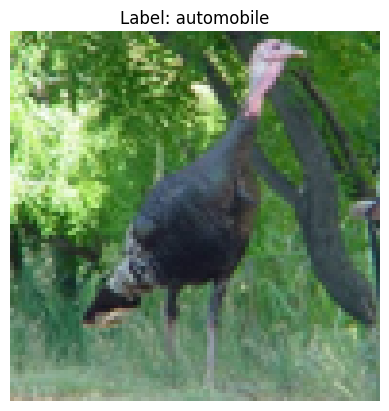

In [11]:
def show_image_with_label(image_tensor, label):
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    image_np = np.transpose(image_tensor.numpy(), (1, 2, 0))
    plt.imshow(image_np)
    plt.title(f'Label: {classes[label]}')
    plt.axis('off')
    plt.show()

show_image_with_label(image, label)

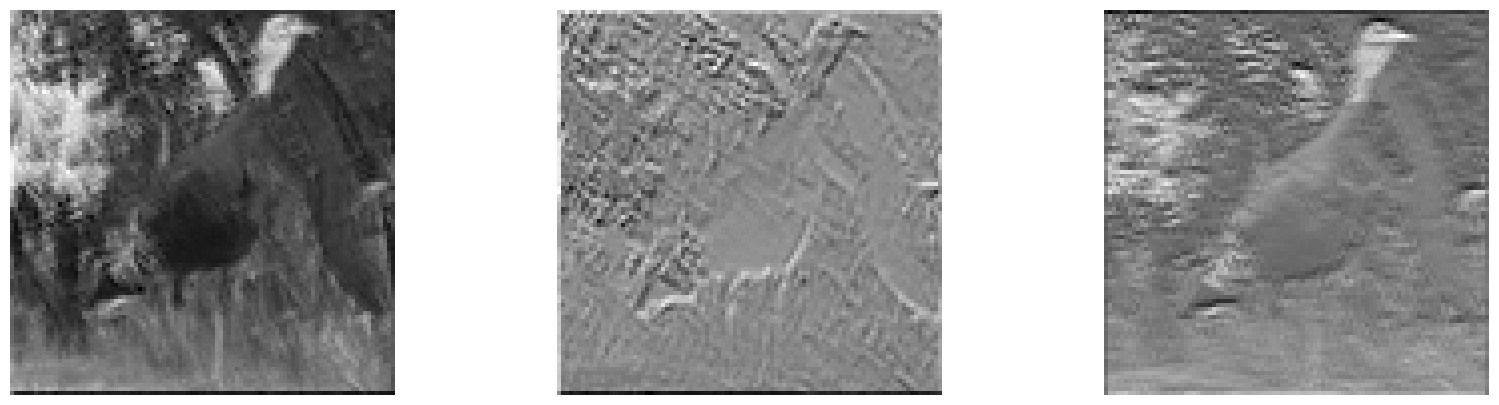

In [12]:
depthwise_model = create_model('depthwise_conv', in_channels=3)
visualize_feature_maps(depthwise_model, image)


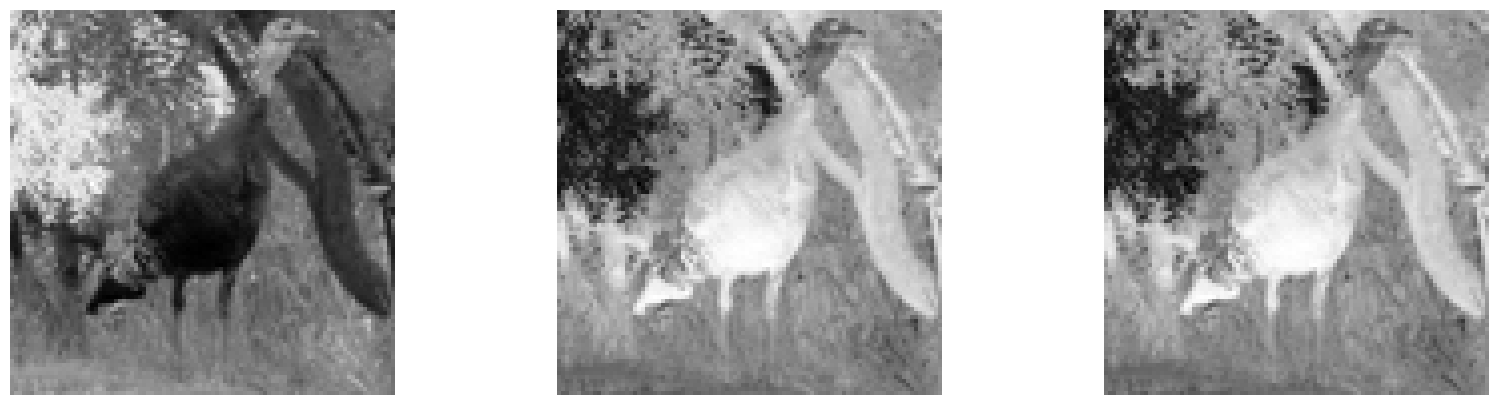

In [15]:
self_attention_model = create_model('self_attention', in_channels=3)
visualize_feature_maps(self_attention_model, image)

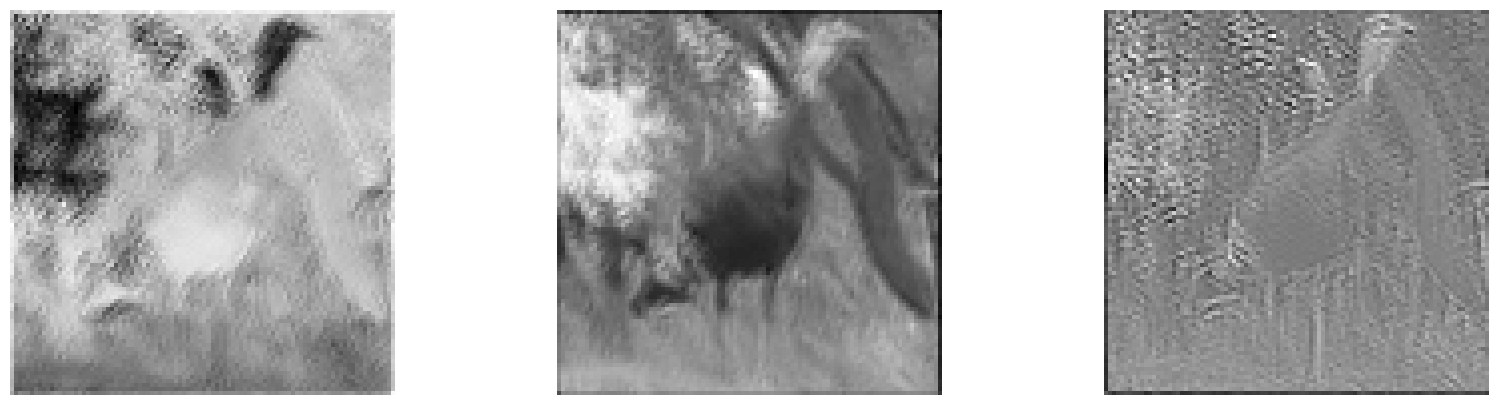

In [16]:
post_norm_model = create_model('post_norm', in_channels=3)
visualize_feature_maps(post_norm_model, image)

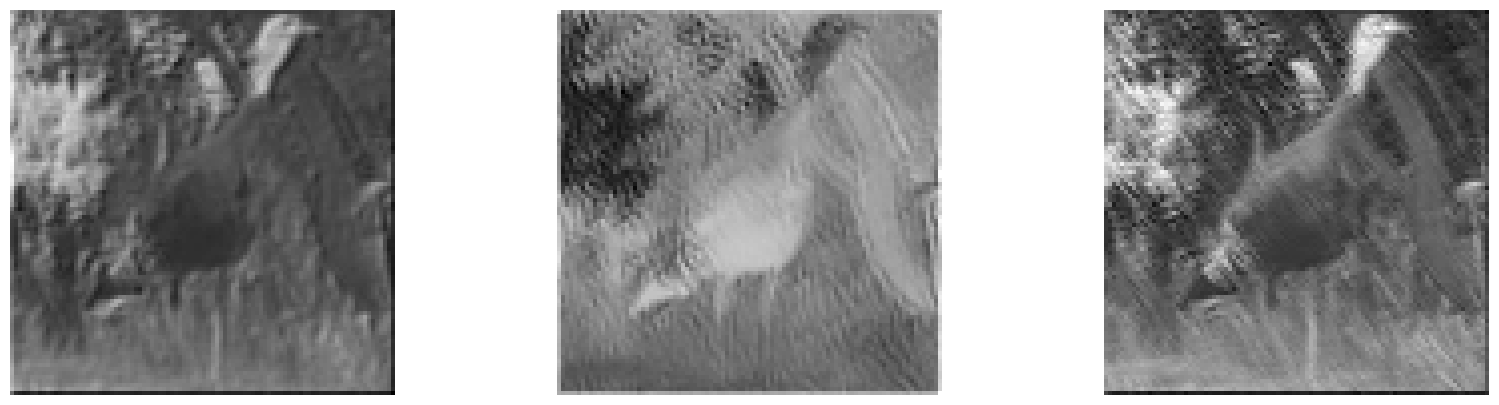

In [17]:
pre_norm_model = create_model('pre_norm', in_channels=3)
visualize_feature_maps(pre_norm_model, image)

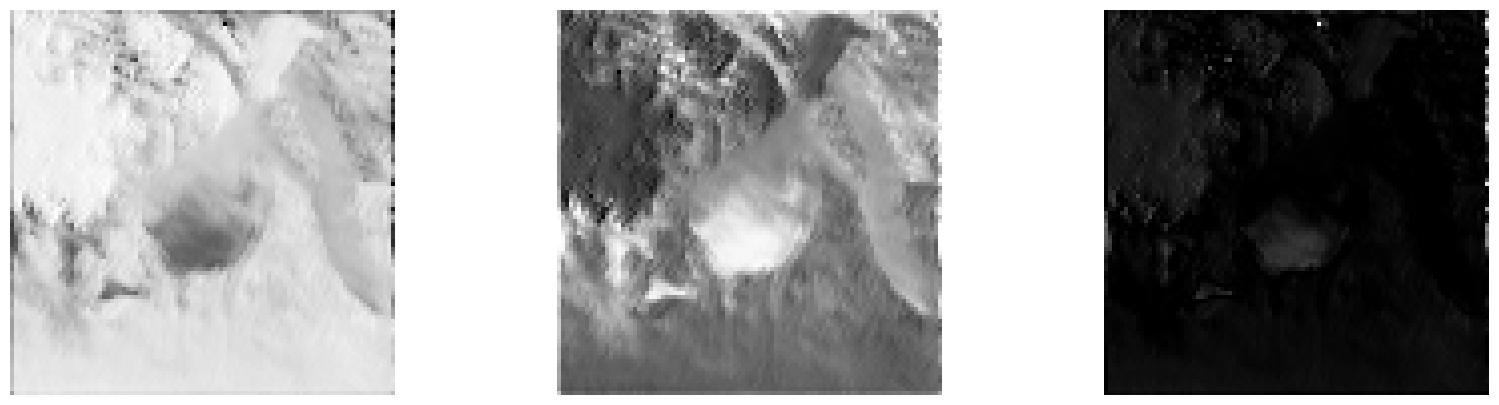

In [42]:
attention_mod_conv_model = create_model('attention_mod_conv', in_channels=3)
image, label = stl10_dataset[2]
visualize_feature_maps(attention_mod_conv_model, image)

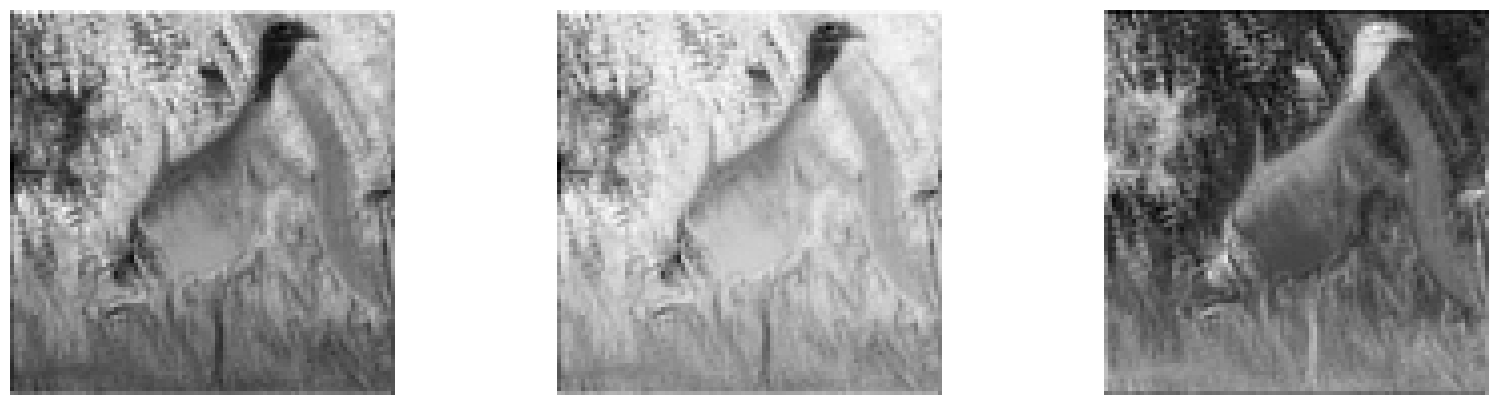

In [41]:
conv_mod_attention_model = create_model('conv_mod_attention', in_channels=3)
image, label = stl10_dataset[2]
visualize_feature_maps(attention_mod_conv_model, image)